In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
%matplotlib inline

total_df = pd.read_pickle('total_df.pckl.gz', compression = 'gzip')

Number of numeric columns:  2840 

AxesSubplot(0.125,0.125;0.775x0.755)


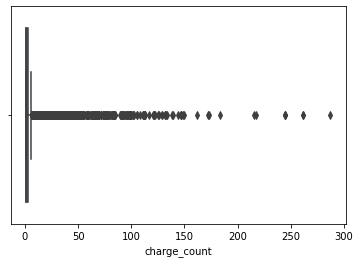

In [2]:
'''
Identifying numeric (non-boolean) columns 
and visualizing distribution/outliers with boxplot of charge_count
'''

bool_cols = [col for col in total_df if np.isin(total_df[col].dropna().unique(), [0, 1]).all()]
non_bool = total_df.columns.difference(bool_cols)
print('Number of numeric columns: ', len(non_bool), '\n')
print(sns.boxplot(x=total_df['charge_count']))

In [3]:
'''
Function to return the fraction of positive instances in inputted subset
'''

def get_portion_true (subset):
    num_true = len(subset[subset['MHI']==1])
    return (num_true/len(subset))

In [4]:
''' 
FEATURE ENGINEERING FOR DATA ANAYLSIS:
create days_since_received feature

chose received because it's the only "start" date without missing values

number of days calculated by subtracting 
from data upload date of December 02, 2019

Useful for censoring analysis
'''

upload_date = pd.to_datetime(pd.datetime.strptime('12/2/2019', '%m/%d/%Y'))
received_date_dt = pd.to_datetime(total_df.received_date)
total_df['days_since_received'] = (upload_date - received_date_dt).astype(str)
total_df['days_since_received'] = total_df['days_since_received'].map(lambda x: x.partition(' ')[0])
total_df['days_since_received'] = total_df['days_since_received'].astype(int)

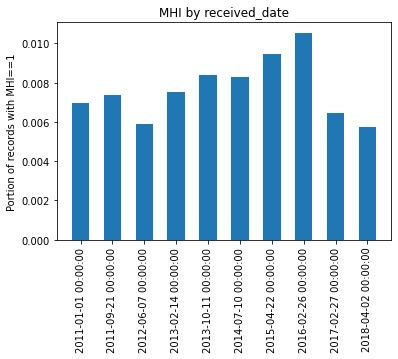

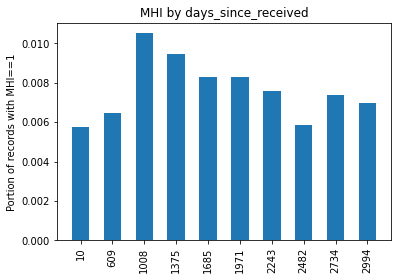

In [5]:
'''
Data Analysis:
Distribution of MHI over Time
'''

def plot_deciles(df, col):

    #get the total number of rows in the df
    n = len(df)

    #sort df by column of interest
    sorted_df = df.sort_values(by=[col])

    #create deciles, ie bins of the column of interest
    decile_1 = sorted_df.iloc[0:round(n/10)]
    decile_2 = sorted_df.iloc[round(n/10):round(2*n/10)]
    decile_3 = sorted_df.iloc[round(2*n/10):round(3*n/10)]
    decile_4 = sorted_df.iloc[round(3*n/10):round(4*n/10)]
    decile_5 = sorted_df.iloc[round(4*n/10):round(5*n/10)]
    decile_6 = sorted_df.iloc[round(5*n/10):round(6*n/10)]
    decile_7 = sorted_df.iloc[round(6*n/10):round(7*n/10)]
    decile_8 = sorted_df.iloc[round(7*n/10):round(8*n/10)]
    decile_9 = sorted_df.iloc[round(8*n/10):round(9*n/10)]
    decile_10 = sorted_df.iloc[round(9*n/10):n]

    #list of deciles
    deciles = [decile_1, decile_2, decile_3, decile_4, decile_5, 
           decile_6, decile_7, decile_8, decile_9, decile_10]

    #create list of portions
    portions = [get_portion_true(x) for x in deciles]

    #create string labels of earliest date in decile
    labels = [str(x.iloc[0][col]) for x in deciles]

    #plot
    fig, ax = plt.subplots()
    ax.bar(labels, portions, width=.55)
    ax.set_xticklabels(labels, rotation = 90)
    ax.set_ylabel('Portion of records with MHI==1')
    plt.title('MHI by {}'.format(col))
    plt.show()
    return

time_features_to_plot = ['received_date', 'days_since_received']

for column in time_features_to_plot:
      plot_deciles(total_df, column)

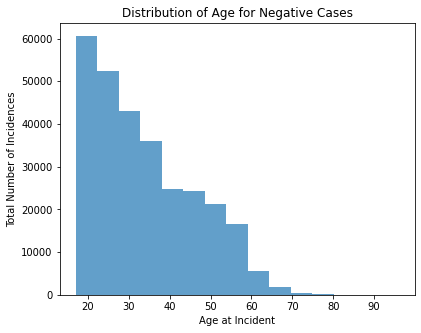

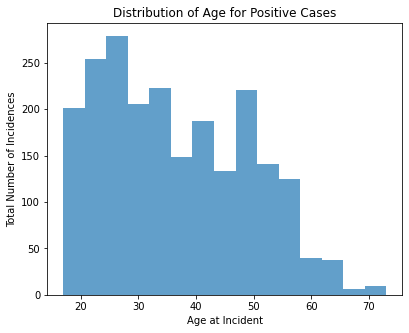

In [6]:
''' 
Data Analysis:
Looking at MHI Base Rates
Across Age
'''

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(total_df['age_at_incident'][total_df['MHI'] == 0], bins=15, alpha = 0.7, label = 'MHI False')
plt.ylabel('Total Number of Incidences')
plt.xlabel('Age at Incident')
plt.title('Distribution of Age for Negative Cases')
plt.show()

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(total_df['age_at_incident'][total_df['MHI'] == 1], bins=15, alpha = 0.7, label = 'MHI True')
plt.xlabel('Age at Incident')
plt.ylabel('Total Number of Incidences')
plt.title('Distribution of Age for Positive Cases')
plt.show()

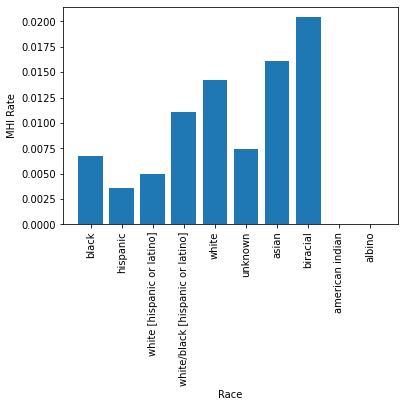

In [7]:
''' 
Data Analysis:
Looking at MHI Base Rates
Across Race
'''

races = ['black', 'hispanic', 'white [hispanic or latino]', 
         'white/black [hispanic or latino]', 'white', 'unknown', 'asian', 
         'biracial', 'american indian', 'albino']

dummy_encoded_races = ['race_' + x for x in races]

race_portions=[]
for i in dummy_encoded_races:
    race_portions.append(get_portion_true(total_df[total_df[i] == 1]))

plt.bar(races, race_portions)
plt.ylabel('MHI Rate')
plt.xlabel('Race')
plt.xticks(races, rotation='vertical')
plt.show()

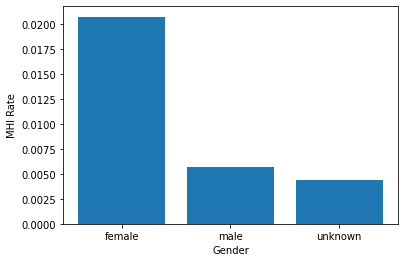

In [8]:
''' 
Data Analysis:
Looking at MHI Base Rates
Across Gender
'''

female = get_portion_true(total_df[total_df['gender_female'] == 1])
male = get_portion_true(total_df[total_df['gender_male'] == 1])
unknown = get_portion_true(total_df[total_df['gender_unknown'] == 1])

gender_portions=[female, male, unknown]
         
plt.bar(['female','male', 'unknown'], gender_portions )
plt.ylabel('MHI Rate')
plt.xlabel('Gender')
plt.show()

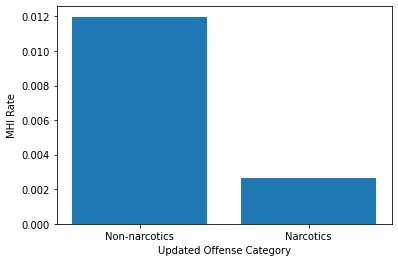

In [9]:
''' 
Data Analysis:
Looking at MHI Base Rates
For narcotics vs. non-narcotics cases

using updated_offense_category_narcotics feature
'''

narcotics0 = get_portion_true(total_df[total_df['updated_offense_category_narcotics'] == 0])
narcotics1 = get_portion_true(total_df[total_df['updated_offense_category_narcotics'] == 1])

portions=[narcotics0, narcotics1]
         
plt.bar(['Non-narcotics','Narcotics'], portions )
plt.ylabel('MHI Rate')
plt.xlabel('Updated Offense Category')
plt.show()

In [10]:
''' 
Data Analysis:
Looking at MHI Base Rates
Across Train/Validation/Test

Calls get_train_val_test from Final_Data_Prep notebook
Train/val/test split will be identical to split used for modelling
Because splitting function strictly time-based, no randomness
'''

from Final_Data_Prep import get_train_val_test
X_train, X_val, X_test, y_train, y_val, y_test = get_train_val_test (total_df, 0.7, 0.15, 0.15)
  
training_df = X_train.join(y_train)
val_df = X_val.join(y_val)
train_and_val_df = pd.concat([training_df, val_df], verify_integrity=True)
test_df = X_test.join(y_test)

print ("Training base rate: ", get_portion_true(training_df))
print ("Validation base rate: ", get_portion_true(val_df))
print ("Training+Validation base rate: ", get_portion_true(train_and_val_df))
print ("Test base rate: ", get_portion_true(test_df))

Training base rate:  0.007684097130940968
Validation base rate:  0.009155059496356425
Training+Validation base rate:  0.007943678020591706
Test base rate:  0.0059958951179577055
